In [1]:
import obi

morphology_containerization_form = obi.MorphologyContainerizationsForm(
                    initialize=obi.MorphologyContainerizationsForm.Initialize(
                        circuit_path=[
                            # obi.NamedPath(name="nbS1-O1", path="/Volumes/4TB/SSCX O1 - release version/O1_data/circuit_config.json"),
                            # obi.NamedPath(name="nbS1-HEX0-beta-L1", path="/Users/pokorny/JupyterLab/git_tmp/obi-output/extracted_subcircuits_test/nbS1-HEX0-beta-L1/circuit_config.json"),
                            # obi.NamedPath(name="nbS1-HEX0-beta-L23", path="/Users/pokorny/JupyterLab/git_tmp/obi-output/extracted_subcircuits_test/nbS1-HEX0-beta-L23/circuit_config.json"),
                            # obi.NamedPath(name="nbS1-HEX0-L1", path="/Users/pokorny/JupyterLab/git_tmp/obi-output/extracted_subcircuits_test/nbS1-HEX0-L1/circuit_config.json"),
                            obi.NamedPath(name="rCA1-CYLINDER-REF", path="/Users/pokorny/Data/rCA1-CYLINDER-REF/circuit_config.json"),
                        ],
                        hoc_template_old = "/Users/pokorny/JupyterLab/git/BluePyEModel/bluepyemodel/export_emodel/templates/cell_template_neurodamus.jinja2",
                        hoc_template_new = "/Users/pokorny/JupyterLab/git/BluePyEModel/bluepyemodel/export_emodel/templates/cell_template_neurodamus_sbo.jinja2"
                    )
)

# grid_scan = obi.GridScan(form=morphology_containerization_form, output_root='/Volumes/4TB/_TMP_CP_/obi-output/morphology_containerization_test', coordinate_directory_option="VALUE")
grid_scan = obi.GridScan(form=morphology_containerization_form, output_root='../../../obi-output/morphology_containerization_test', coordinate_directory_option="VALUE")

# TODO: Check with multiple node populations with same/different morph and hoc folders
#       Add containerization to MorphIO at some point + documentation

In [2]:
grid_scan.run()

Info: Running morphology containerization for 'rCA1-CYLINDER-REF'
Copying circuit to output folder...
...DONE
> 1584 unique morphologies in population 'hippocampus_neurons' (6213)


Merging .h5 into container: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1584/1584 [00:01<00:00, 1292.86it/s]

INFO: Merged 1584 morphologies into container (0 already existed)



Traceback (most recent call last):
  File "/Users/pokorny/JupyterLab/git_tmp/obi-one/obi/modeling/morphology_containerization/morphology_containerization.py", line 171, in run
    _pop["alternate_morphologies"]["h5v1"] = os.path.join(os.path.split(_pop["morphologies_dir"])[0], self.CONTAINER_FILENAME)  # FIXME
                                                                        ~~~~^^^^^^^^^^^^^^^^^^^^
KeyError: 'morphologies_dir'


In [7]:
def load_morphology(nodes, nid, extension='asc'):
    def _sec_points(sec, soma_pos):
        """Connect all root sections to the soma."""
        if sec.is_root:
            return np.vstack([soma_pos, sec.points])
        else:
            return sec.points
    get_tgt_morph = lambda node_id: nodes.morph.get(node_id, transform=True, extension=extension) # Access function (incl. transformation!), using ASCII format
    nrn_morph = get_tgt_morph(nid)  # Target morphology
    soma_pos = nrn_morph.soma.center
    dd_types = list(filter(lambda tp: "dendrite" in tp.name, nm.NEURITE_TYPES))  # Select dendrite types
    dd_sel = np.isin(nrn_morph.section_types, dd_types)
    dd_points = [_sec_points(_sec, soma_pos) for _sel, _sec in zip(dd_sel, nrn_morph.sections) if _sel]  # Dendrite points
    ax_types = list(filter(lambda tp: "axon" in tp.name, nm.NEURITE_TYPES))  # Select dendrite types
    ax_sel = np.isin(nrn_morph.section_types, ax_types)
    ax_points = [_sec_points(_sec, soma_pos) for _sel, _sec in zip(ax_sel, nrn_morph.sections) if _sel]  # Axon points
    return soma_pos, dd_points, ax_points

def plot_morph(soma_pos, dd_points, ax_points, soma_color="k", dd_style={"fmt": "k-"}, ax_style=None, label=None):
    if soma_color is not None:
        plt.plot(*soma_pos, "o", color=soma_color, alpha=1.0, markeredgecolor="none", label=label)
    if dd_style is not None:
        dd_style = dd_style.copy()
        dd_fmt = dd_style.pop("fmt", "")
        for _i, _p in enumerate(dd_points):
            plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], dd_fmt, **dd_style)
    if ax_style is not None:
        ax_style = ax_style.copy()
        ax_fmt = ax_style.pop("fmt", "")
        for _i, _p in enumerate(ax_points):
            plt.plot(_p[:, 0], _p[:, 1], _p[:, 2], ax_fmt, **ax_style)

In [20]:
# Load circuit
import matplotlib.pyplot as plt
import neurom as nm
import numpy as np
from bluepysnap import Circuit
circuit_config = "/Users/pokorny/JupyterLab/git_tmp/obi-output/morphology_containerization_test/nbS1-HEX0-beta-L23/circuit_config.json"
c = Circuit(circuit_config)
nodes = c.nodes["S1nonbarrel_neurons"]
print(f"INFO: Loaded circuit with {nodes.size} neurons")

INFO: Loaded circuit with 8173 neurons


/Users/pokorny/JupyterLab/git_tmp/obi-output/morphology_containerization_test/nbS1-HEX0-beta-L23/morphologies/merged-morphologies.h5


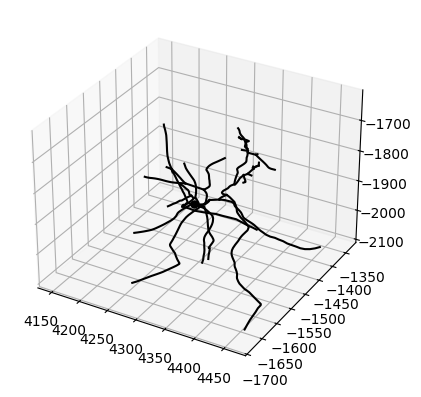

In [21]:
plt.figure()
plt.gcf().add_subplot(projection="3d")
morph_data = load_morphology(nodes, 0, extension="h5")  # h5 ... From container
print(nodes.morph._get_morphology_base("h5"))  # Verify use of container
plot_morph(*morph_data)
plt.show()